#  This is Lab 2 executable file
This file contains the program code that is the solution to the tasks from the file [lab_2_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_2/lab_2_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [18]:
# libs initialization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.optimize import curve_fit 
import seaborn as sns
import urllib.request
import os
from datetime import datetime, timedelta
from prettytable import PrettyTable

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [19]:
# Dataset initialization
path_to_file = '../Datasets/match_map_stats.csv'
source_df = pd.read_csv(path_to_file, engine='python')
# source_df.columns = ["V"+str(i) for i in range(1, len(source_df.columns)+1)]  # rename column names to be similar to R naming convention
# source_df.V2 = source_df.V2.astype(str)
source_df.head(7)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,Los Angeles Valiant,San Francisco Shock,75.61505,0.00000,0.00000,240.00000,NaN,NaN,2,0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,Los Angeles Valiant,San Francisco Shock,75.64960,75.61505,125.75057,0.00000,NaN,NaN,3,2
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,Los Angeles Valiant,San Francisco Shock,0.00000,0.00000,250.49200,240.00000,NaN,NaN,2,0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,Los Angeles Valiant,San Francisco Shock,0.00000,0.00000,225.78903,250.49200,NaN,NaN,2,2
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,Los Angeles Valiant,San Francisco Shock,0.00000,0.00000,36.39606,250.49200,NaN,NaN,4,2
5,2018-01-11 00:51:16,2018-01-11 00:56:55,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,4,...,Los Angeles Valiant,San Francisco Shock,0.00000,0.00000,0.00000,36.39606,NaN,NaN,3,4
6,2018-01-11 01:11:32,2018-01-11 01:16:33,Overwatch League - Stage 1,10223,3,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Ilios,1,...,Los Angeles Valiant,San Francisco Shock,0.00000,0.00000,0.00000,0.00000,99.00000,100.00000,0,1


Date:        date and time the game was auto-played

Level:       the 3-digit number is an estimate of the difficulty from a previous run

NumBlocks:   how many blocks have to be broken to win the level

IsWin:       True if autoplay broke all the blocks, False if the ball fell past the paddle

ElapsedTime: Seconds until either won or lost (game is played at 4x speed, so multiply by 4 to get an estimate of how long a human might play it)

Score:       total score when the game was won or lost

Accuracy:    the autoplay is tuned with a randomly-chosen accuracy. Higher numbers are more likely to win;

In [20]:
# Colums renaming and data preparation

# Recretion of timestamps columns in length of the game column
source_df['round_start_time'] = source_df['round_start_time'].astype(str)
source_df['round_end_time'] = source_df['round_end_time'].astype(str)
glength = []
for i in range(0, len(source_df['round_start_time'])):
    finaltime = datetime.strptime(source_df['round_end_time'][i], '%Y-%m-%d %H:%M:%S')
    starttime = datetime.strptime(source_df['round_start_time'][i], '%Y-%m-%d %H:%M:%S')
    td = finaltime - starttime
    glength.append(td.seconds)
source_df['game_length'] = glength
source_df['game_length'] = source_df['game_length'].astype(int)

# deleting unused columns
# source_df = source_df.drop(['round_start_time', 'round_end_time', 'match_id', 'attacker_control_perecent',	'defender_control_perecent', 'team_one_name', 'team_two_name', 'control_round_name'], axis = 1)
source_df = source_df[['attacker_round_end_score', # this is the value we will predict (target)
                        'map_name', # this is our category sorter
                        'game_length', # all other values are the predictors
                        'defender_round_end_score', 
                        'game_number', 
                        'map_round', 
                        'attacker_payload_distance', 
                        'defender_payload_distance', 
                        'winning_team_final_map_score', 
                        'losing_team_final_map_score']]

# show new dataset
source_df.head(7)


,attacker_round_end_score,map_name,game_length,defender_round_end_score,game_number,map_round,attacker_payload_distance,defender_payload_distance,winning_team_final_map_score,losing_team_final_map_score
0,2,Dorado,480,0,1,1,75.61505,0.00000,3,2
1,3,Dorado,354,2,1,2,75.64960,75.61505,3,2
2,2,Temple of Anubis,230,0,2,1,0.00000,0.00000,4,3
3,2,Temple of Anubis,254,2,2,2,0.00000,0.00000,4,3
4,4,Temple of Anubis,219,2,2,3,0.00000,0.00000,4,3
5,3,Temple of Anubis,339,4,2,4,0.00000,0.00000,4,3
6,0,Ilios,301,1,3,1,0.00000,0.00000,2,1


In [21]:
# plt.figure(figsize=(13, 8))

# kernel = scipy.stats.gaussian_kde(source_df['game_length'])

# min_amount, max_amount = source_df['game_length'].min(), source_df['game_length'].max()
# x = np.linspace(min_amount, max_amount, len(source_df)) # by defaul 50 items
# kde_values = kernel(x)

# # sns.histplot(source_df[col_name], kde=False, stat="density", label=f'Average transaction size in rubles')
# # Draw unnormed histogramm
# hist_data = plt.hist(source_df['game_length'], density=True, bins=50)

# # print(hist_vals)
# plt.plot(x, kde_values, color="r")

# plt.ylabel('p')
# plt.xlabel('Average transaction size')

# plt.legend()
# plt.show()

## Exercise №1
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

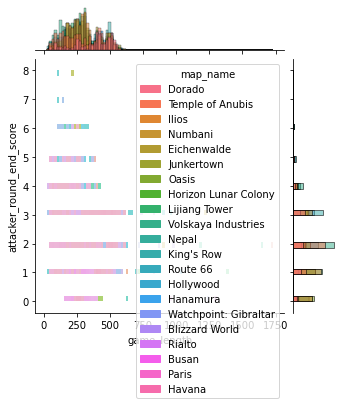

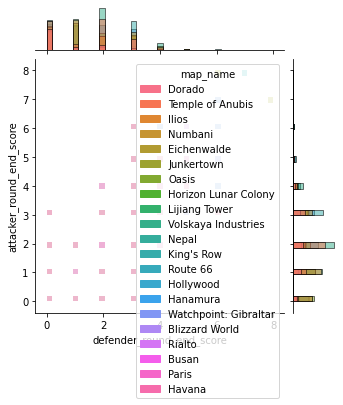

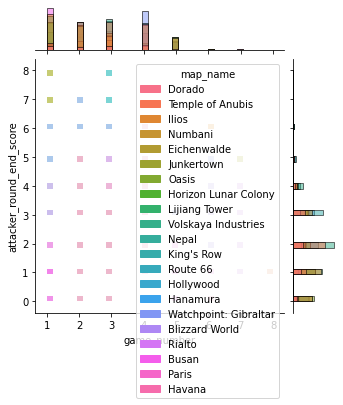

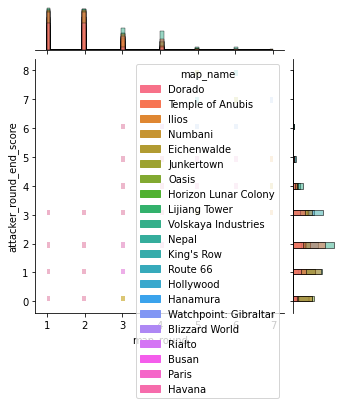

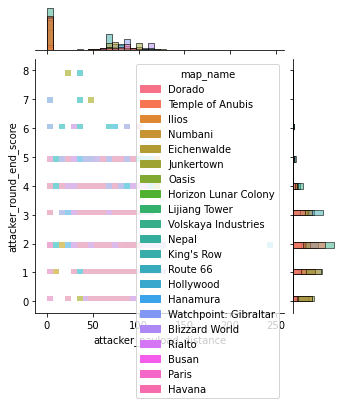

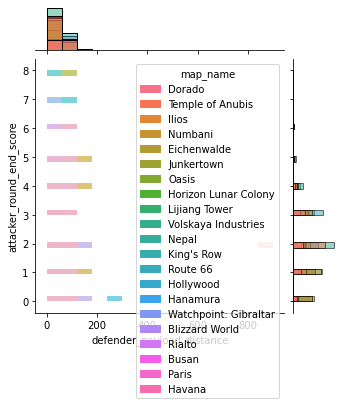

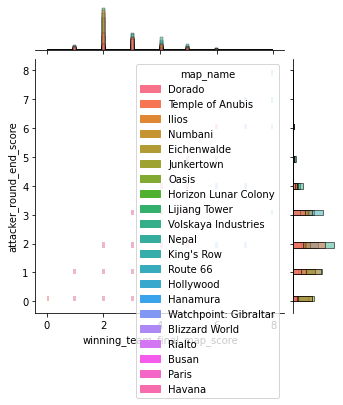

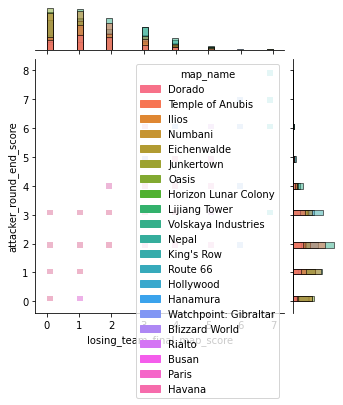

In [22]:
ilist = source_df.columns.tolist()
for i in range(2, len(ilist)):
    sns.jointplot(data=source_df, x=source_df[ilist[i]], y=source_df['attacker_round_end_score'], hue=source_df['map_name'], height=5, kind="hist")
    

## Exercise №2
You need to make an estimation of multivariate mathematical expectation and variance.

In [38]:

table = PrettyTable()
table.field_names = ["Column name", "mathematical expectation", "variance"]
for i in range(0, len(ilist)-1):
    table.add_row([str(ilist[i]), str(source_df.mean()[i]), str(source_df.var()[i])])
print(table)

/var/folders/ky/fcbbxgqj4xbchr5qk956cd3r0000gn/T/ipykernel_4784/2413917550.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  table.add_row([str(ilist[i]), str(source_df.mean()[i]), str(source_df.var()[i])])


+------------------------------+--------------------------+--------------------+
|         Column name          | mathematical expectation |      variance      |
+------------------------------+--------------------------+--------------------+
|   attacker_round_end_score   |    1.8165033522434244    | 1.5366783024180992 |
|           map_name           |    300.9255286230015     | 18102.96845798079  |
|         game_length          |    1.2698298091799898    | 1.663516115038699  |
|   defender_round_end_score   |    2.6126869520371327    | 1.5876459155043772 |
|         game_number          |    1.9026302217637958    | 0.9362577810341471 |
|          map_round           |    30.342056479805706    | 1618.7961274581205 |
|  attacker_payload_distance   |    19.134520005442052    | 1403.639978408622  |
|  defender_payload_distance   |    2.7281072717895825    | 1.2609130151059766 |
| winning_team_final_map_score |    1.4707581227436823    | 1.7142005289661475 |
+---------------------------

## Exercise №3
You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances. 

In [ ]:
print(subdataset[subdataset.Level=='520'].mean())
print(subdataset[subdataset.Level=='520'].var(ddof=1))
print(subdataset[subdataset.Level=='493'].mean())
print(subdataset[subdataset.Level=='493'].var(ddof=1))

## Exercise №4
You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

In [ ]:
pairs = [
    ['Score', 'ElapsedTime'],
    ['Score', 'Accuracy'],
    ['Score', 'NumBlocks'],
    ['Score', 'Date']
    # ['Accuracy', 'Market Cap'],

    # ['Dividend Yield', '52 Week Low'],
    # ['Dividend Yield', '52 Week High'],
    # ['Dividend Yield', 'Earnings/Share'],
    # ['Dividend Yield', 'Market Cap'],

    # ['52 Week Low', '52 Week High'],
    # ['52 Week Low', 'Earnings/Share'],
    # ['52 Week Low', 'Market Cap'],

    # ['52 Week Low', 'Earnings/Share'],
    # ['52 Week Low', 'Market Cap'],

    # ['Earnings/Share', 'Market Cap']
]
for x, y in pairs:
    r, p = scipy.stats.pearsonr(subdataset[x], subdataset[y])
    r_z = np.arctanh(r)  # matches Fisher transform
    # Corresponding standard deviation
    se = 1/np.sqrt(subdataset[x].size-3)
    alpha = 0.05
    z = scipy.stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se

    print('Conf int for the corr coef {} & {}: {:.4f}:{:.4f} '.format(x, y, lo_z, hi_z))


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Exercise №5
Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

In [ ]:
# Linear Regression without scaling

# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression()
# Train a linear regression model
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_, reg.coef_)
print('model parameters:')
print('model weights:', reg.coef_)
print('model bias:', reg.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', reg.score(X_test, y_test))

## Exercise №6-7 (Without regulariztion)
6. Build regression model and make an analysis of multicollinearity and regularization (if needed). 
7. Analyze the quality of regression model (distribution of residuals, determination coefficient).

In [ ]:
# Linear Regression without Regularization

# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression()
# Train a linear regression model
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
y_train = pd.DataFrame(scaler.fit_transform(y_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
y_test = pd.DataFrame(scaler.fit_transform(y_test))
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_, reg.coef_)
print('model parameters:')
print('model weights:', reg.coef_)
print('model bias:', reg.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', reg.score(X_test, y_test))


In [ ]:
# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
X = pd.DataFrame(scaler.fit_transform(X))
y_pred_all = reg.predict(X)
y = pd.DataFrame(scaler.fit_transform(y))
y1 = np.array(y)
y2 = np.array(y_pred_all)
print(y1[:,0].shape)
y_diff = y1[:,0] - y2[:,0]
sns.displot(y_diff, kde=False)

## Exercise №6-7 (With regulariztion)
6. Build regression model and make an analysis of multicollinearity and regularization (if needed). 
7. Analyze the quality of regression model (distribution of residuals, determination coefficient).

In [ ]:

# Linear Regression with Regularization

# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
lasso = Lasso(alpha=0.1)
# Train a linear regression model
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
y_train = pd.DataFrame(scaler.fit_transform(y_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
y_test = pd.DataFrame(scaler.fit_transform(y_test))
lasso.fit(X_train, y_train)
# Forecast on a test sample
y_pred = np.expand_dims(lasso.predict(X_test), 1)
params = np.append(lasso.intercept_, lasso.coef_)
print('model parameters:')
print('model weights:', lasso.coef_)
print('model bias:', lasso.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', lasso.score(X_test, y_test))

In [ ]:
# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
X = pd.DataFrame(scaler.fit_transform(X))
y_pred_all = np.expand_dims(lasso.predict(X), 1)
y = pd.DataFrame(scaler.fit_transform(y))
y1 = np.array(y)
y2 = np.array(y_pred_all)
print(y1[:,0].shape)
y_diff = y1[:,0] - y2[:,0]
sns.displot(y_diff, kde=False)